# Assignment 10 Math Foundations Machine Learning
## David Alvear 187594

In [117]:
import torch
import time
import math
import random
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## 1. RNN for classification

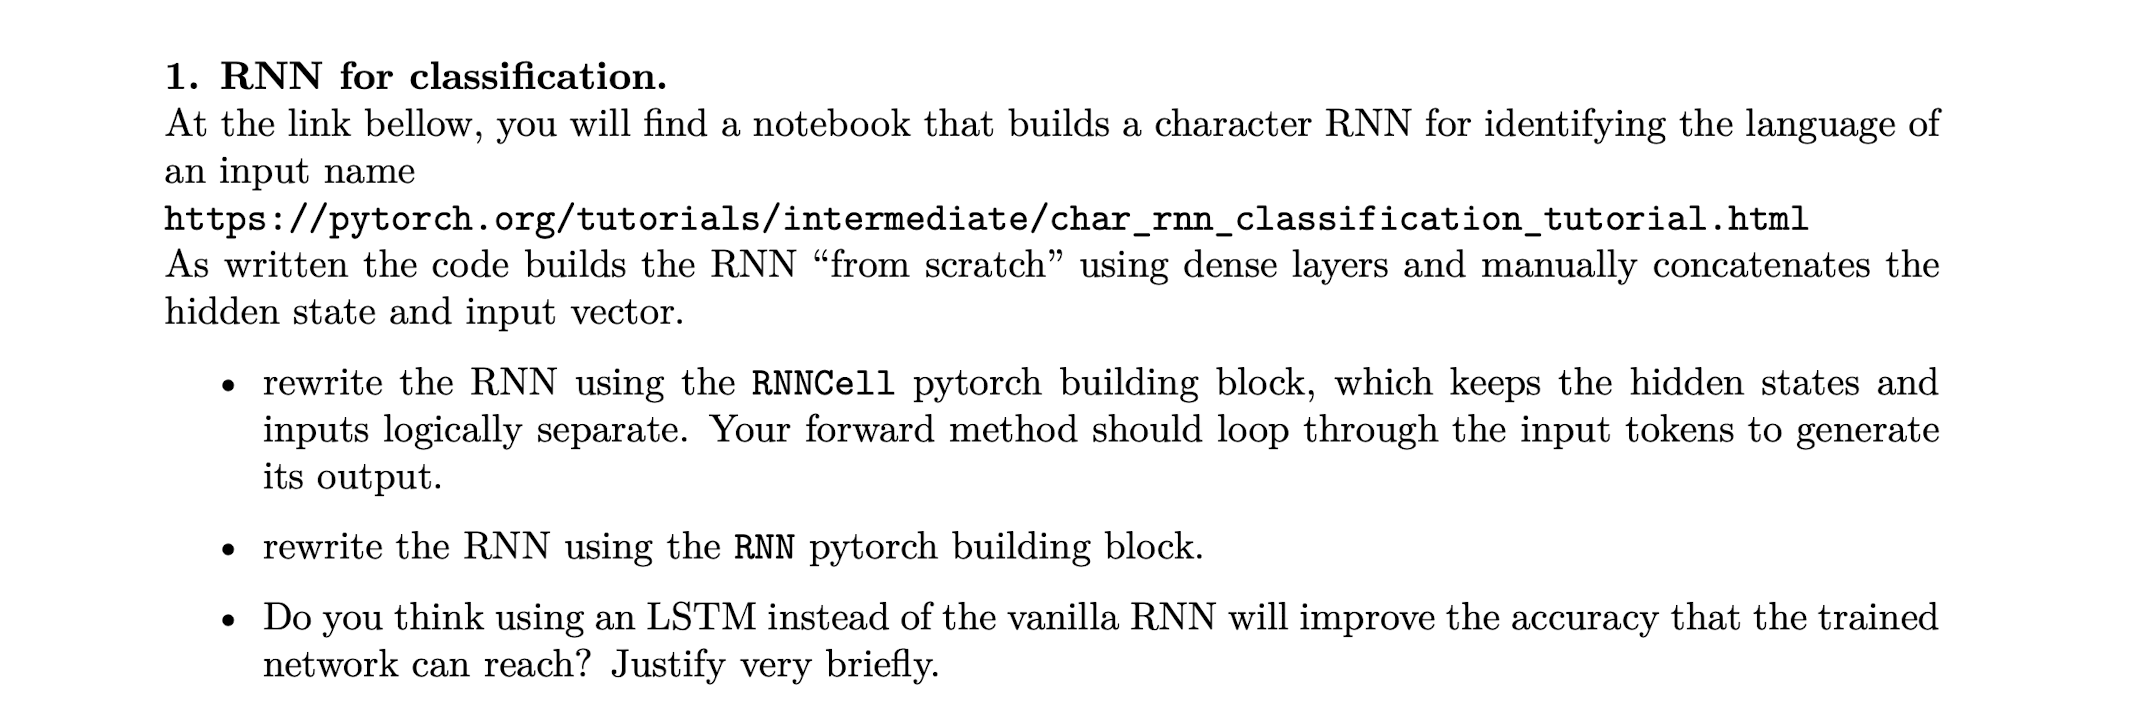

### Original Model

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### RNN Cell

In [154]:
class RNNCellSimple(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCellSimple, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.RNNCell(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        outputs = []
        for i in range(input.size(0)):
            hidden = self.i2h(input[i], hidden) 
            output = self.h2o(hidden)
            output = self.softmax(output)
            outputs.append(output)
        
        return torch.stack(outputs), hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNNCellSimple(n_letters, n_hidden, n_categories)

### RNN

In [ ]:
class RNNSimple(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCellSimple, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input.unsqueeze(1), hidden.unsqueeze(0))
        output = self.h2o(hidden.squeeze(0))
        output = self.softmax(output)
        return output, hidden.squeeze(0)


    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### Comments
Indeed, the use of LSTMs can outperform the vanilla RNNS. LSTMs are designed when it is required long-term data learning. LSTMs help to mitigate the problem of vanishing gradients. Additionally, the use of additional gates such us input, forget, output and cell state helps to maintain longer memory pass data. In the provided example LSRMs are likely to have better results than RNN due to the importance of the context in language identification.

## 2. RNN for generation

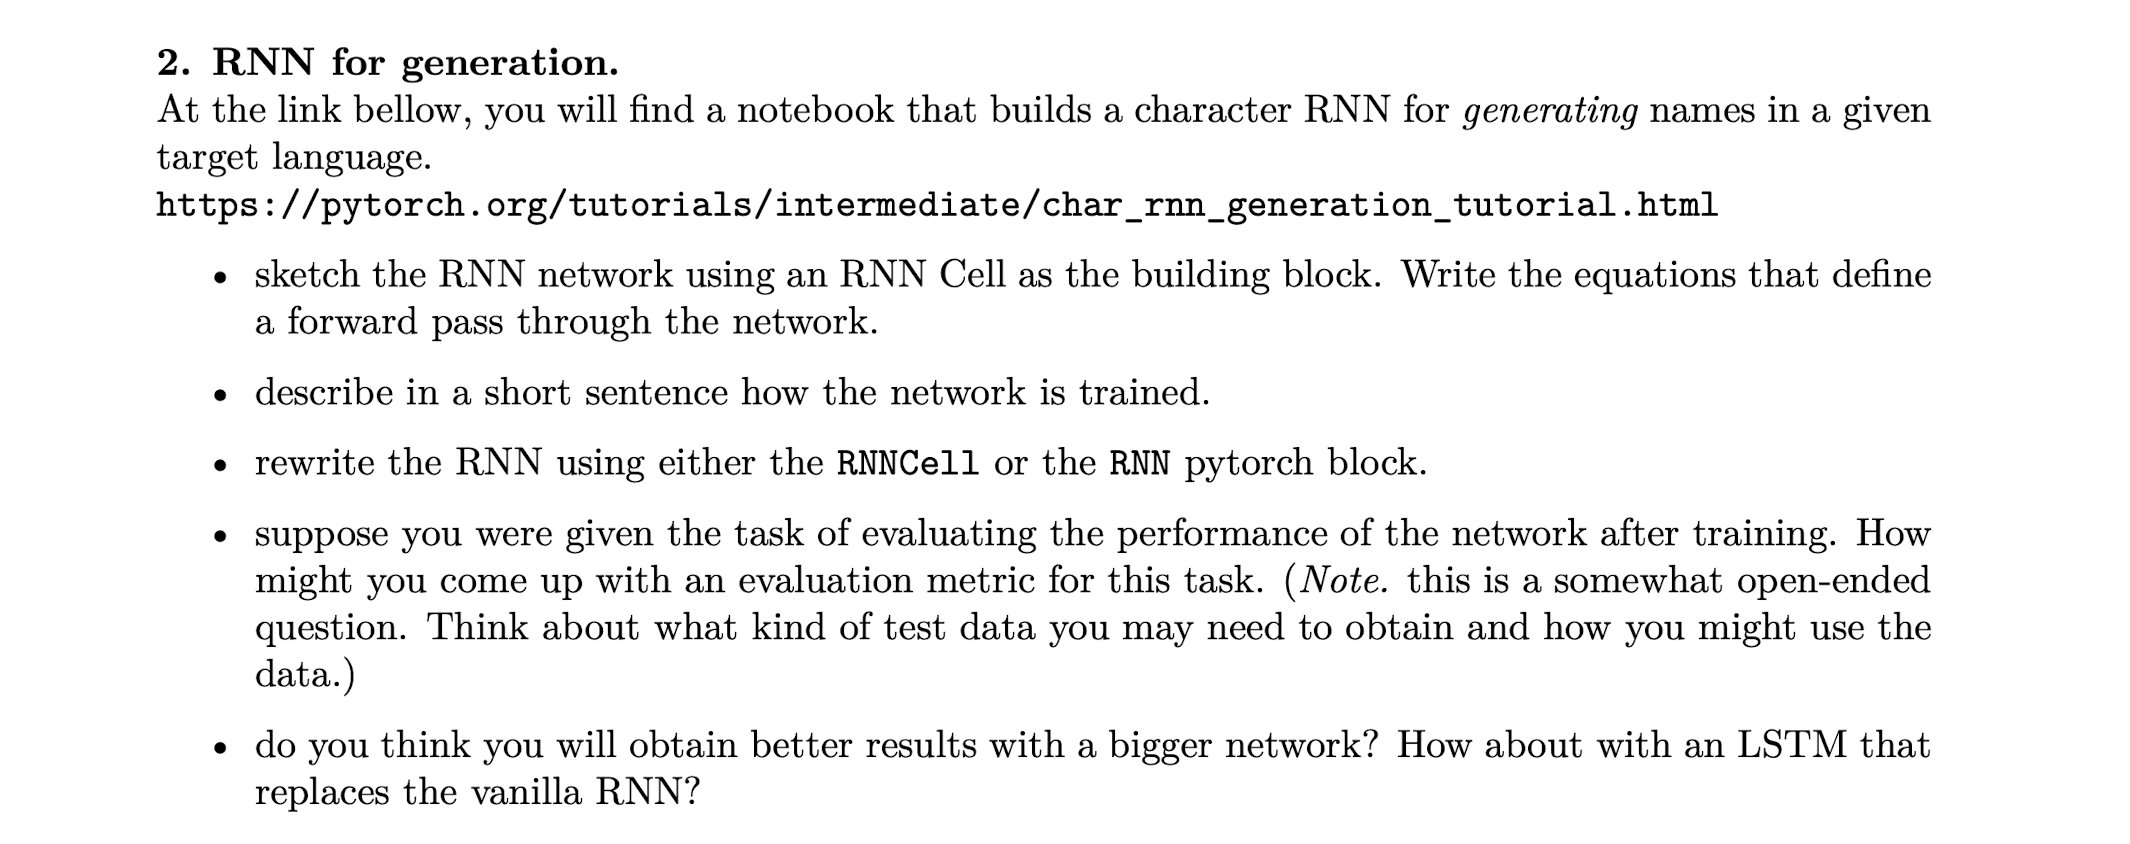

In [118]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('../data/rnn_class_data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 1 ['eng-fra']
O'Neal


### RNNCell model

This application can be interpreted as many to many RNN.

In [150]:
class RNNCellModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCellModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_i2h = nn.RNNCell(n_categories + input_size, hidden_size)
        self.rnn_i2o = nn.RNNCell(n_categories + input_size, hidden_size)
        self.o2o = nn.Sequential(
            nn.Linear(hidden_size + hidden_size, output_size),
            nn.Dropout(0.1),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input), 1)
        hidden = self.rnn_i2h(input_combined, hidden)
        output = self.rnn_i2o(input_combined, hidden)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [151]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [152]:
criterion = nn.NLLLoss()
learning_rate = 0.0005
rnn = RNNCellModel(n_letters, 128, n_letters)
# rnn = RNNModel(n_letters, 128, n_letters)
n_iters = 2
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

### How is the network trained?

The network is trained generating a prediction at every time step, the recurrent model take the hidden state and input state of previous time step to generate the new prediction. This model can be classified as many to many architecture to generate new data given a previous timestep.

### Model evaluation

To evaluate the model after training we can use a separate dataset (test_dataset) with data that the model has not seen during training. We can use the Perplexity evaluation metric, it measures how well a probability model predicts a sample. Lower perplexity better prediction. For the data, we can prepare test names categorized by langiage. For each name use the model to generate a name in the category and compare the generated with the actual label and evaluate using metrics.

### Large network and LSTM?

Using LSTMs can improve the accuracy of the model because it can capture long=range dependencues in the sequence. That could improve the generation of the names. A large network can improve the accuracy identifying more complex patterns with the risk of overfitting.

## 3. Understanding Word2Vec

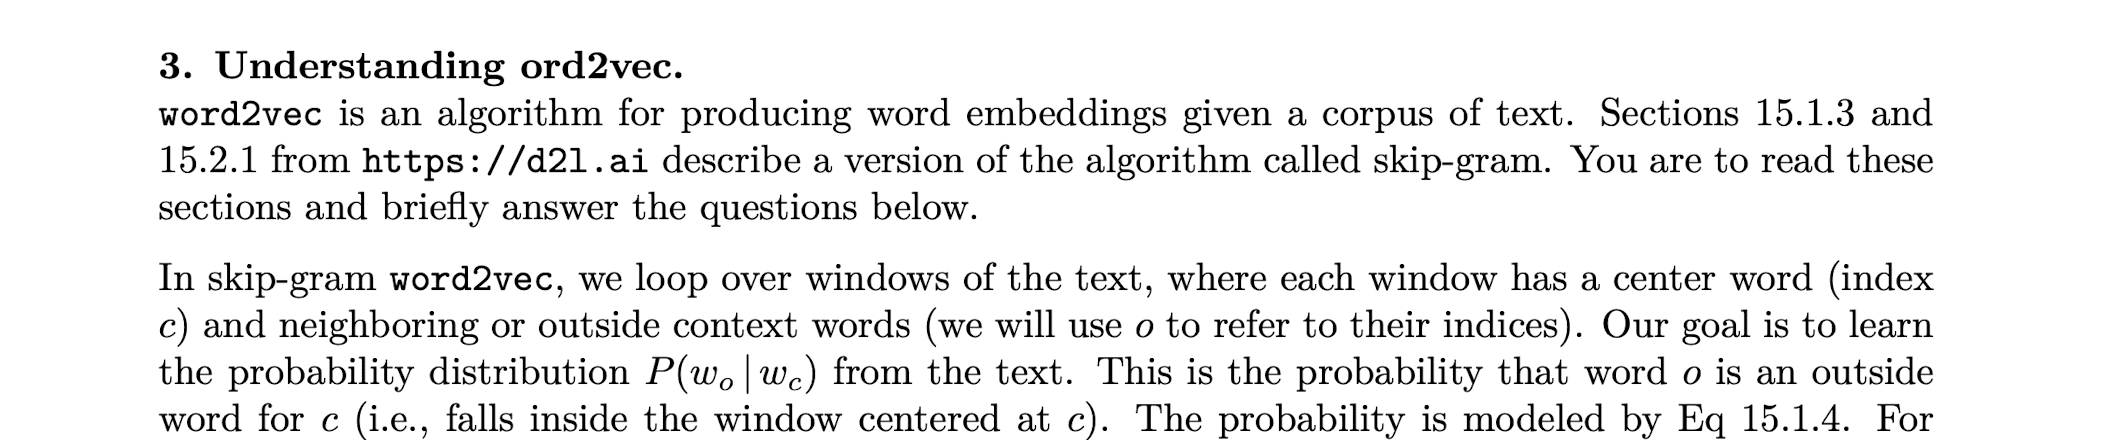
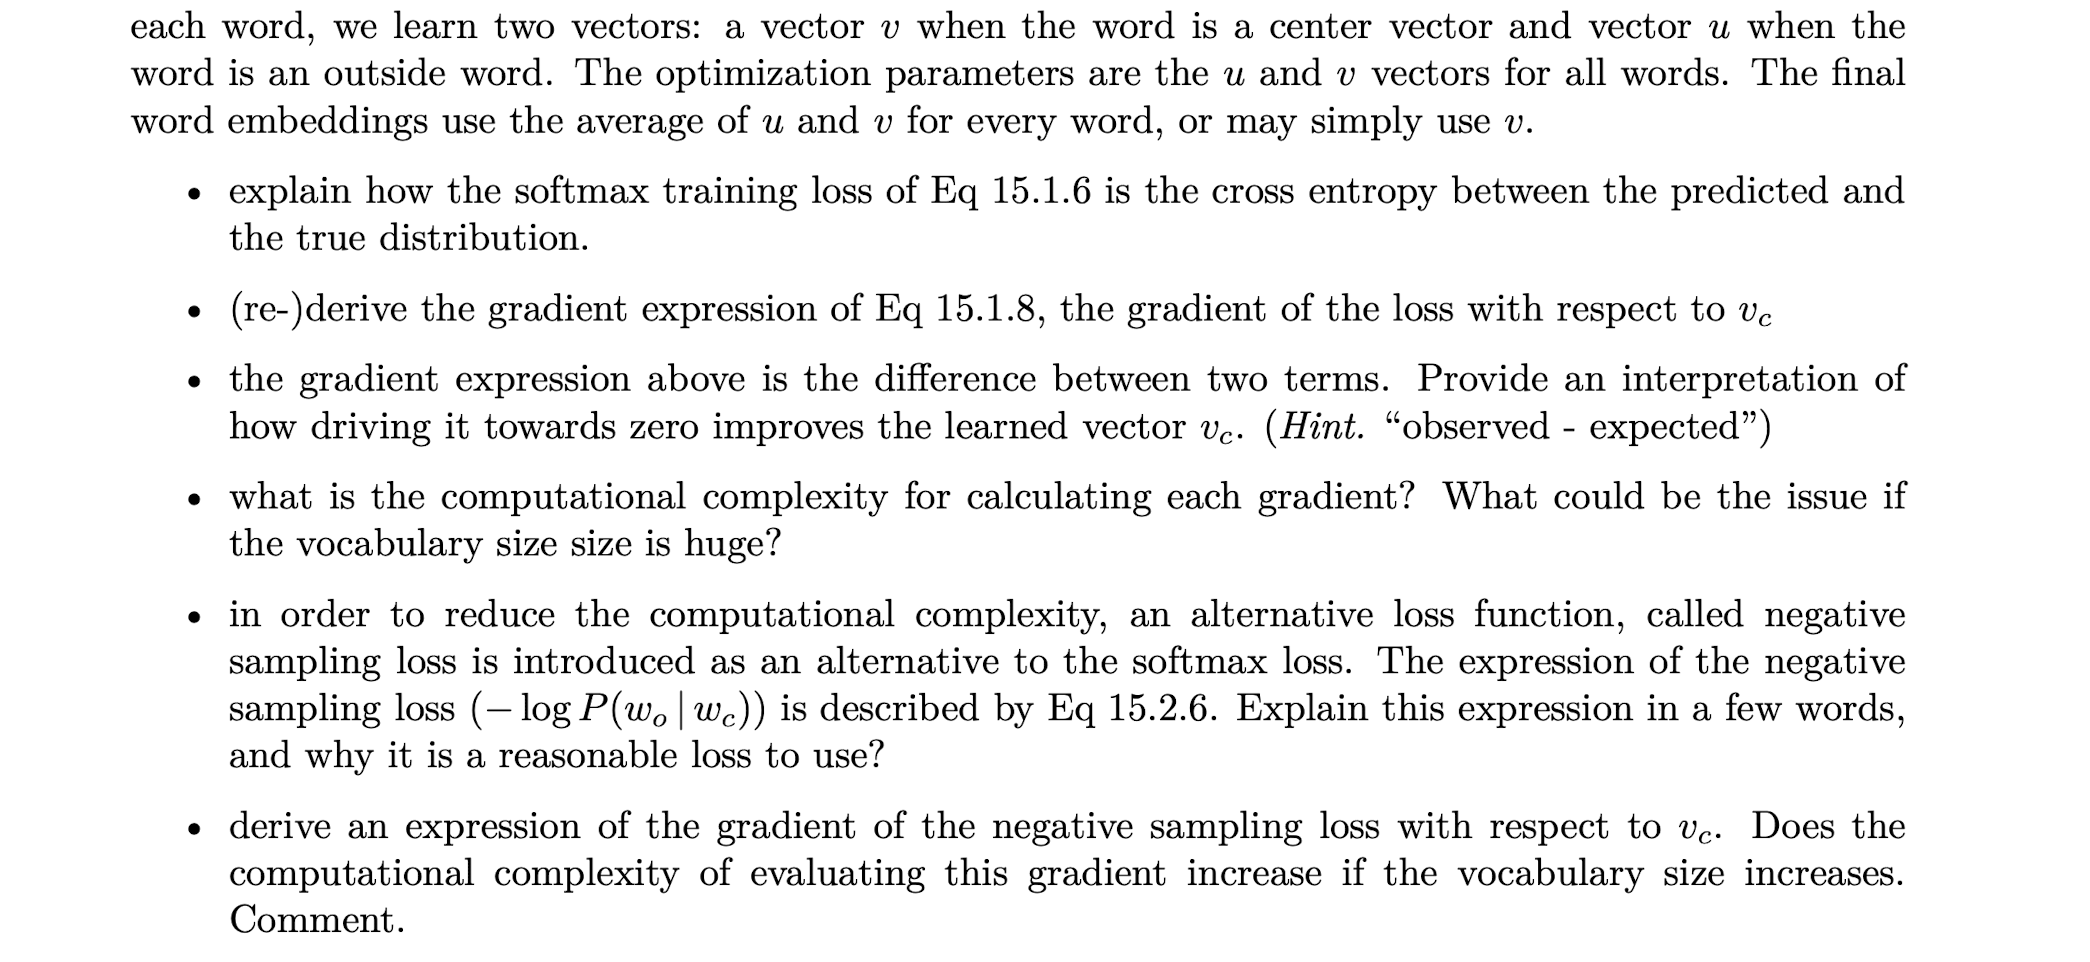

### Check the solution in the pdf file